# **Multi-Label Emotion Recognition System**


# **Step 1: Environment Setup**
### First, let's install required libraries and configure our environment

In [2]:
!pip install transformers datasets scikit-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.7 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.4.0.6 which is incompatible.
torch 2.6.0+

In [28]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset, concatenate_datasets
from transformers import (
    AutoTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from sklearn.metrics import f1_score, hamming_loss

# ──────────────────────────────────────────────────────────────────────────────
# Step 2: DATA LOADING AND PREPROCESSING
# ──────────────────────────────────────────────────────────────────────────────

In [34]:
# Load GoEmotions
dataset = load_dataset("go_emotions")

In [35]:
# Remove unwanted columns (we only need text and labels)
def remove_columns(example):
    return {'text': example['text'], 'labels': example['labels']}

dataset = dataset.map(remove_columns, remove_columns=['id'])

In [36]:
# Showing a few samples to inspect data
print("Sample record:")
print(dataset["train"][0])
print(dataset)

Sample record:
{'text': "My favourite food is anything I didn't have to cook myself.", 'labels': [27]}
DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 5427
    })
})


# ──────────────────────────────────────────────────────────────────────────────
# Step 3: VISUALIZE ORIGINAL LABEL DISTRIBUTION
# ──────────────────────────────────────────────────────────────────────────────

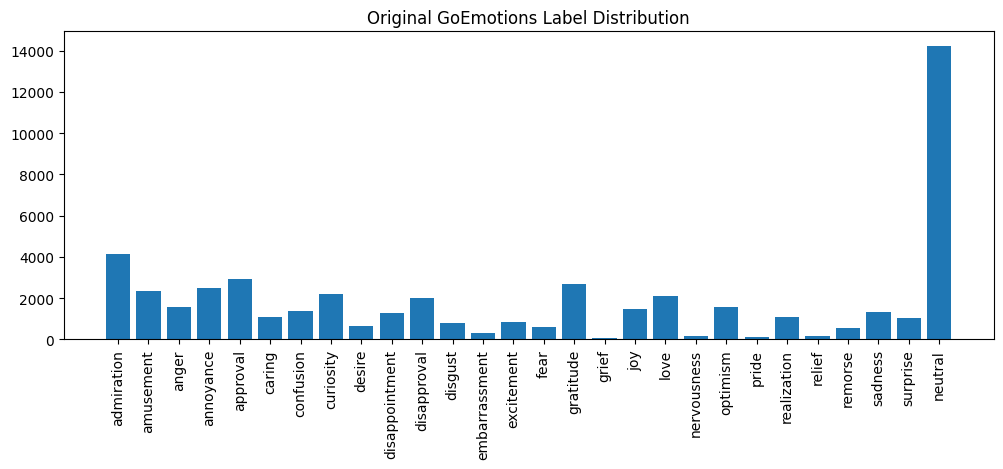

In [37]:
label_names = dataset['train'].features['labels'].feature.names
num_labels   = len(label_names)

# Count occurrences
counts = np.sum([np.bincount(ex['labels'], minlength=num_labels)
                 for ex in dataset['train']], axis=0)

plt.figure(figsize=(12,4))
plt.bar(label_names, counts)
plt.xticks(rotation=90)
plt.title("Original GoEmotions Label Distribution")
plt.show()

# ──────────────────────────────────────────────────────────────────────────────
# Step 4. TOKENIZATION & MULTI‑HOT ENCODING
# ──────────────────────────────────────────────────────────────────────────────

In [38]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_and_encode(ex):
    enc = tokenizer(ex['text'],
                    padding='max_length',
                    truncation=True,
                    max_length=128)
    # build float multi‑hot labels
    mh = [0.0]*num_labels
    for idx in ex['labels']:
        mh[idx] = 1.0
    enc['labels'] = mh
    return enc

encoded = dataset.map(tokenize_and_encode, batched=False)

# Cast 'labels' to torch.float32 tensors
def cast_labels(ex):
    ex['labels'] = torch.tensor(ex['labels'], dtype=torch.float32)
    return ex

encoded = encoded.map(cast_labels)

# Prepare PyTorch format
encoded.set_format(type='torch',
                   columns=['input_ids','attention_mask','labels'])

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

# ──────────────────────────────────────────────────────────────────────────────
# Step 5. COMPUTE pos_weight PER LABEL
# ──────────────────────────────────────────────────────────────────────────────

In [39]:
# Stack all label vectors to count positives
all_lbls   = torch.stack([ex['labels'] for ex in encoded['train']])
label_pos  = all_lbls.sum(dim=0)            # positives
n_samples  = all_lbls.size(0)
label_neg  = n_samples - label_pos

pos_weight = (label_neg / label_pos).clamp(min=1.0)
# .clamp(min=1.0) ensures we don’t get zero or negative weights
print("pos_weight:", pos_weight)

pos_weight: tensor([  9.5109,  17.6469,  26.7026,  16.5749,  13.7703,  38.9356,  30.7325,
         18.8129,  66.7223,  33.2080,  20.4688,  53.7415, 142.2673,  49.8910,
         71.8356,  15.3073, 562.7662,  28.8967,  19.8102, 263.6951,  26.4573,
        390.0811,  38.1081, 282.7255,  78.6514,  31.7376,  39.9528,   2.0530])


# ──────────────────────────────────────────────────────────────────────────────
# Step 6. DEFINE CUSTOM DATA COLLATOR (FLOAT LABELS)
# ──────────────────────────────────────────────────────────────────────────────

In [40]:
class DataCollatorWithFloatLabels(DataCollatorWithPadding):
    def __call__(self, features):
        batch = super().__call__(features)
        batch['labels'] = torch.stack(
            [f['labels'].to(dtype=torch.float32) for f in features]
        )
        return batch

data_collator = DataCollatorWithFloatLabels(tokenizer)

# ──────────────────────────────────────────────────────────────────────────────
# Step 7. DEFINE WeightedTrainer WITH pos_weight
# ─────────────────────────────────────────────────────────────────────────────

In [53]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.BCEWithLogitsLoss(
            pos_weight=pos_weight.to(logits.device)
        )
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# ──────────────────────────────────────────────────────────────────────────────
# Step 8. MODEL & TRAINING ARGUMENTS
# ──────────────────────────────────────────────────────────────────────────────

In [47]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

training_args = TrainingArguments(
    output_dir="./checkpoints",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    learning_rate=2e-5,
    
    logging_dir="./logs",
    logging_steps=50,

    report_to="none" 
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# ──────────────────────────────────────────────────────────────────────────────
# Step 9. METRICS FUNCTION
# ──────────────────────────────────────────────────────────────────────────────

In [55]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))
    # Threshold at 0.5
    preds = (probs > 0.5).astype(int)
    return {
        "f1": f1_score(labels, preds, average="micro"),
        "hamming_loss": hamming_loss(labels, preds)
    }

# ──────────────────────────────────────────────────────────────────────────────
# Step 10. INITIALIZE & RUN TRAINER
# ──────────────────────────────────────────────────────────────────────────────

In [57]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=encoded['train'],
    eval_dataset=encoded['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

/tmp/ipykernel_35/3868610563.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,F1,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
1,0.466900,0.676107,0.405472,0.098691,22.930100,236.632000,3.707000
2,0.488600,0.654379,0.412284,0.097750,22.894400,237.001000,3.713000
3,0.370000,0.692758,0.440181,0.085468,22.788500,238.102000,3.730000
4,0.308100,0.769165,0.472418,0.073903,22.837900,237.588000,3.722000
5,0.267600,0.794581,0.472590,0.072824,22.897100,236.973000,3.712000


TrainOutput(global_step=6785, training_loss=0.3937532659655735, metrics={'train_runtime': 3143.3299, 'train_samples_per_second': 69.051, 'train_steps_per_second': 2.159, 'total_flos': 1.42803965293056e+16, 'train_loss': 0.3937532659655735, 'epoch': 5.0})

# ──────────────────────────────────────────────────────────────────────────────
# Step 11: SAVE MODEL
# ──────────────────────────────────────────────────────────────────────────────

In [59]:
output_dir = "/kaggle/working/goemotions_model"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)
print("Model saved to:", output_dir)

Model saved to: /kaggle/working/goemotions_model


# ──────────────────────────────────────────────────────────────────────────────
# Step 12: ZIP THE TRAINED MODEL TO DOWNLOAD LOCALLY
# ──────────────────────────────────────────────────────────────────────────────

In [63]:
!zip -r goemotions_model.zip goemotions_model

updating: goemotions_model/ (stored 0%)
updating: goemotions_model/training_args.bin (deflated 52%)
updating: goemotions_model/model.safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 7%)
updating: goemotions_model/tokenizer.json (deflated 71%)
updating: goemotions_model/tokenizer_config.json (deflated 75%)
updating: goemotions_model/special_tokens_map.json (deflated 42%)
updating: goemotions_model/config.json (deflated 65%)
updating: goemotions_model/vocab.txt (deflated 53%)


# ──────────────────────────────────────────────────────────────────────────────
# Step 13: EVALUATION ON TEST SPLIT
# ──────────────────────────────────────────────────────────────────────────────

In [64]:
test_metrics = trainer.evaluate(eval_dataset=encoded['test'])
print("Test set metrics:", test_metrics)

Test set metrics: {'eval_loss': 0.8065202236175537, 'eval_f1': 0.46800591687741566, 'eval_hamming_loss': 0.07336992287241044, 'eval_runtime': 24.2611, 'eval_samples_per_second': 223.691, 'eval_steps_per_second': 3.504, 'epoch': 5.0}


# ──────────────────────────────────────────────────────────────────────────────
# Step 14: RELOAD MODEL TO TEST ON REAL DATA
# ──────────────────────────────────────────────────────────────────────────────

In [65]:
# (Re)load
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [67]:
def predict_emotions(text, thresh=0.5):
    enc = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        logits = model(**enc).logits
        probs  = torch.sigmoid(logits)[0].cpu().numpy()
    return [label_names[i] for i,p in enumerate(probs) if p>thresh]

# Examples
print(predict_emotions("I’m so happy and proud of my results!"))
print(predict_emotions("This makes me nervous and a bit sad."))

['admiration', 'excitement', 'gratitude', 'joy', 'pride']
['fear', 'grief', 'nervousness', 'sadness']


In [72]:
# More testing

print(predict_emotions("This is so sad"))
print(predict_emotions("I’m so done with you"))
print(predict_emotions("It will be an honour"))

['disappointment', 'sadness']
['anger', 'annoyance', 'disapproval', 'disgust']
['admiration', 'gratitude']
